In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import scipy
import scipy.integrate as integrate
from scipy.special import gamma, factorial
from scipy.integrate import quad
from scipy.stats import poisson

In [2]:
def k_rational(x, a=-14):
    return x/(x+a)



def k_exp(x, a=-14, alpha=1 ):
    return 1-alpha*np.exp(np.abs(x)/a)

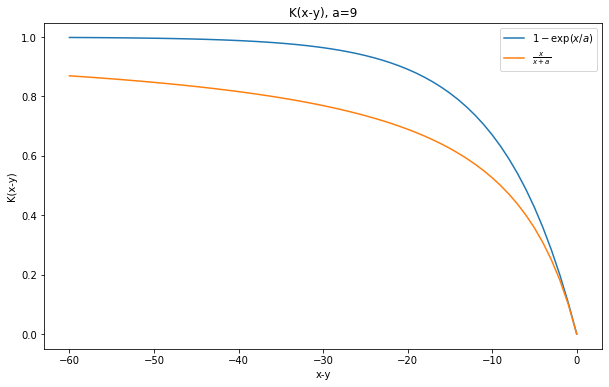

In [3]:
a=-9

aend = -60
x = np.linspace(aend, 0, abs(aend)+1)

Kexp = k_exp(x, a)
Krat = k_rational(x, a)

plt.figure(figsize=(10, 6))

plt.plot(x, Kexp, label = r"$1 -\exp(x/a)$")
plt.plot(x, Krat, label = r"$\frac{x}{x+a}$")

plt.ylabel("K(x-y)")
plt.xlabel("x-y")

plt.title("K(x-y), a=9")
plt.legend(loc="best")


In [4]:
def GetAntigeneticMatrix(n_shtamms):

    mn = np.linspace(-n_shtamms+1, 0 , n_shtamms, dtype = int)
 
 
    K = []

    for i in range(len(mn)):
        k_temp = []
        for j in range(len(mn)):
            if (j>i):
                k_temp.append(k_rational(i-j, a))
            elif (j==i):
                k_temp.append(0)
            else:
                k_temp.append(0)

        K.append(k_temp)

    K=np.array(K)
 
    K += 0.
    
    return K

Text(0, 0.5, 'x - new ')

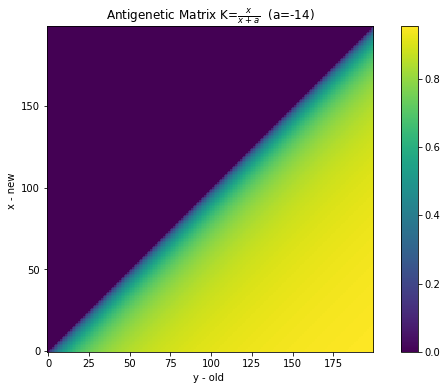

In [5]:
n_shtamms = 200
K = GetAntigeneticMatrix(n_shtamms)


plt.figure(figsize=(10, 6))
plt.yticks(np.arange(0, n_shtamms, 50))

plt.imshow(K,  origin = 'lower')

plt.colorbar()
 
plt.title(r"Antigenetic Matrix K=$\frac{x}{x+a}$  (a=-14)")

plt.xlabel("y - old ")
plt.ylabel("x - new ")

In [6]:
def GetIntialVectors(n_shtamms=300):
    N_populations = (n_shtamms) * 1000000

    r0 = np.zeros((1, n_shtamms)).T
    i0 = np.zeros((1, n_shtamms)).T
 

    r0[:20] = 0.999*N_populations/20 


    i_all = 0.001 * N_populations  
    ic = i_all

    i0[20] = i_all 

    return i0/N_populations, r0/N_populations, N_populations

In [7]:

U_b = 0.0000058

def mutations_move(infected, N_populations=-1, U_b = 0.0058 ):
    
    if(N_populations==-1):
        N_populations = 1000000*len(infected)
    
    new_infections = np.zeros(len(infected)-1)
    for i in range(len(infected)):
        if (infected[i]!=0 ):
            
            if(infected[i]<0):
                continue 
                
            mean_moves = U_b * infected[i] * N_populations
            
            r = poisson.rvs(mean_moves) #распределение Пуассона 
            
            new_infections[i] = r #r - число, которое пойдет в следующий (передний) бин 
            
    return new_infections/N_populations

def change_infected(i_current, i_mutated):
    """i_mutated короче на один"""
    
    for i in range(len(i_mutated)):
        if(i_mutated[i]!=0):
            i_current[i] = i_current[i] - i_mutated[i]
            i_current[i+1] = i_current[i+1] + i_mutated[i]
 
        

1.0


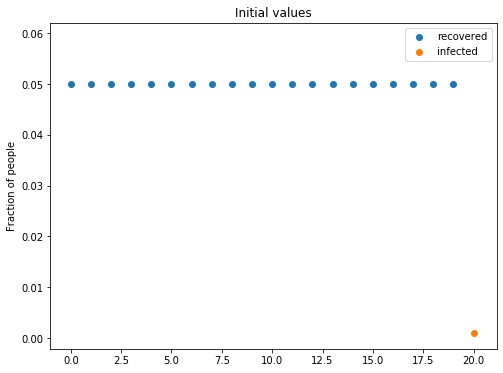

In [8]:
n_shtamms = 200
K = GetAntigeneticMatrix(n_shtamms)
i0, r0, N_populations = GetIntialVectors(n_shtamms )

r0_show = r0.copy()
r0_show [r0_show ==0 ] = np.nan

i0_show = i0.copy()
i0_show [i0_show ==0 ] = np.nan


plt.figure(figsize=(8, 6))

plt.scatter(np.arange(0, n_shtamms, 1), r0_show, label = "recovered")
plt.scatter(np.arange(0, n_shtamms, 1), i0_show, label = "infected")

plt.title("Initial values")
plt.ylabel("Fraction of people")

plt.legend()

print(np.sum(r0) + np.sum(i0))

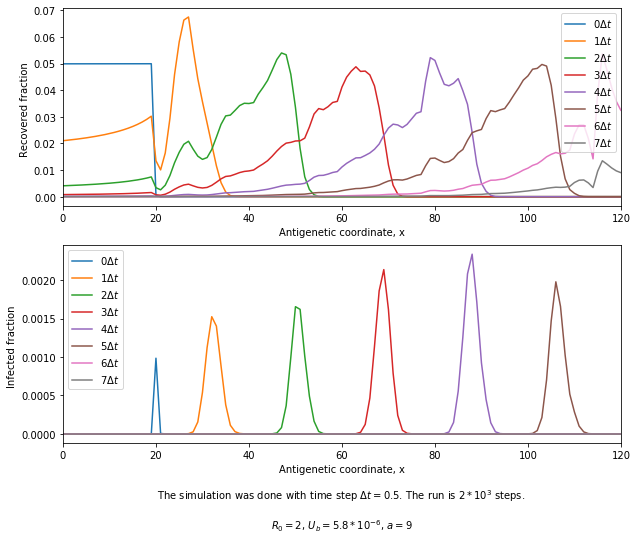

In [9]:
plt.figure(figsize=(10, 8))

ax1 = plt.subplot(211)
plt.xlabel("Antigenetic coordinate, x")
plt.ylabel("Recovered fraction ") 
plt.xlim(0,120)

ax2 = plt.subplot(212)
sim=r"The simulation was done with time step $\Delta t=0.5$. The run is $2 \times 10^3$ steps. "
txt = r"$R_0=2$, $U_b=5.8*10^{-6}$, $a=9$"
plt.xlabel('''Antigenetic coordinate, x

The simulation was done with time step $\Delta t=0.5$. The run is $2 * 10^3$ steps. 

$R_0=2$, $U_b=5.8*10^{-6}$, $a=9$
''')
plt.xlim(0,120)
plt.ylabel("Infected fraction ")

nsteps = 2000
h = 0.5 #time step 

r_initial = r0.copy()
i_initial = i0.copy()

R0 = 2.0


r_time = [np.sum(r0)]
i_time = [np.sum(i0)]
 

r_all_time = r0 
i_all_time = i0 
w_all_time = R0*np.dot(K.T, r0)-1

c = [] 

for i in range(nsteps):
    P = np.dot(K, i0)
    Q = np.dot(K.T, r0)

    r1 = r0*(1-h*R0*P) +h*i0
    i1 = i0*(1+h*R0*Q-h)
    
    w1 = R0*np.dot(K.T, r1)-1  #для w считаю сразу с приростом
     

    i_moves = mutations_move(i1)
    change_infected(i1, i_moves)
 
    if(i%250==0): 
        ax1.plot(r1, label=str(i//250) + r"$\Delta t$")
 
        ax2.plot(i1, label=str(i//250) + r"$\Delta t$")
    
    r0 = r1.copy()
    i0 = i1.copy()
    
    r_time.append(np.sum(r0) )
    i_time.append(np.sum(i0))
    
    r_all_time = np.hstack((r_all_time, r0))
    i_all_time = np.hstack((i_all_time, i0))
    
    new_c = i_time[-1]*np.pi*np.abs(a)/2.0/R0
    c.append(new_c)
    w_all_time = np.hstack((w_all_time, w1))
 
ax1.legend()  
ax2.legend()  
 
#sim=r"The simulation was done with time step $\Delta t=0.5$. The run is $2 \times 10^3$ steps. "
#txt = r"$R_0=2$, $U_b=5.8*10^{-6}$, $a=9$"
#plt.text(.5, .05, sim+txt, ha='center')
#ax2.set_xlabel(r'\begin{center}Antigenetic coordinate, x\\*\textit{\small{' + sim + txt + r'}}\end{center}')

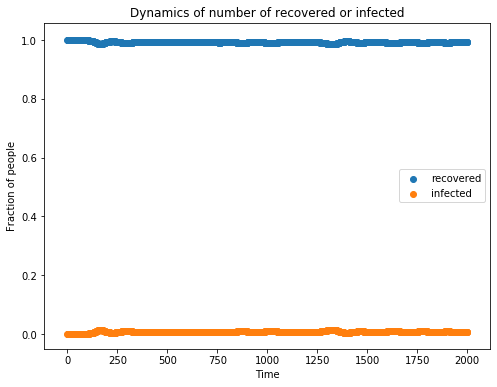

In [10]:
plt.figure(figsize=(8, 6))

plt.scatter(np.arange(len(r_time)), r_time, label = "recovered")
plt.scatter(np.arange(len(i_time)),i_time, label = "infected")

plt.title("Dynamics of number of recovered or infected")
plt.xlabel("Time")
plt.ylabel("Fraction of people")
plt.legend()

1.0


Text(0, 0.5, 'Fraction of infected')

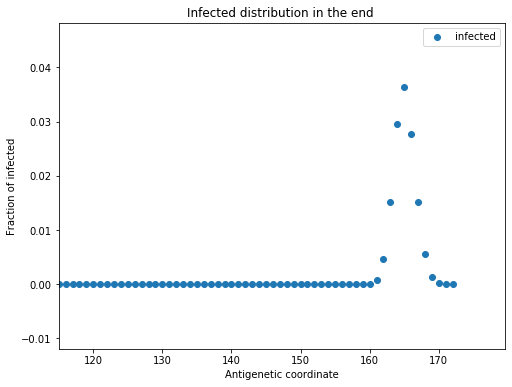

In [11]:
r_initial1=r_initial
r_initial1[r_initial1==0] = np.nan
i_initial1=i_initial
i_initial1[i_initial1==0] = np.nan

r0_show = r1.copy()
r0_show [r0_show ==0 ] = np.nan

i0_show = i1.copy()
i0_show [i0_show ==0 ] = np.nan


plt.figure(figsize=(8, 6))

#plt.scatter(np.arange(0, n_shtamms, 1), r0_show, label = "recovered", c= "k")
plt.scatter(np.arange(0, n_shtamms, 1), 20*i0_show, label = "infected")

#plt.scatter(np.arange(0, n_shtamms, 1), r_initial1, marker = "s", label = "recovered start")
#plt.scatter(np.arange(0, n_shtamms, 1), i_initial1, marker = "s", label = "infected start", alpha = 0.5)

#plt.title("Initial values")

plt.legend()

print(np.sum(r0) + np.sum(i0))
plt.xlim(115)

plt.title("Infected distribution in the end ")
plt.xlabel("Antigenetic coordinate")
plt.ylabel("Fraction of infected")

Ниже симуляция визуализирована цветовыми картами, где цвет - концентрация/доля.
Это только для любителей.

Text(0, 0.5, 'Antigenetic coordinate')

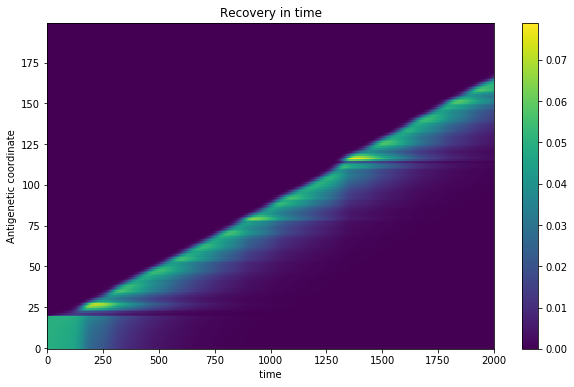

In [12]:

plt.figure(figsize=(10, 6))


#r_all_time[r_all_time==0] = np.nan

plt.imshow(r_all_time,  origin = 'lower', aspect = "auto")

plt.colorbar()
 
plt.title("Recovery in time")

plt.xlabel(" time ")
plt.ylabel("Antigenetic coordinate")

Text(0, 0.5, 'Antigenetic coordinate')

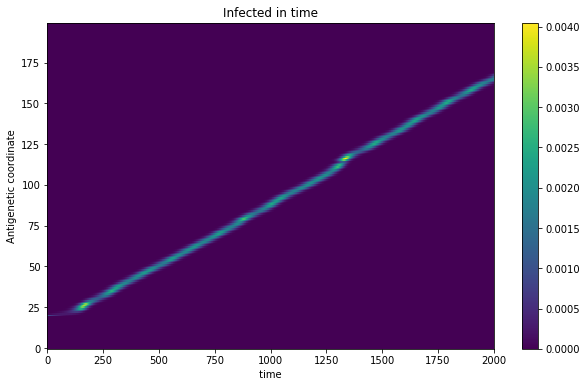

In [13]:

plt.figure(figsize=(10, 6))


#r_all_time[r_all_time==0] = np.nan

plt.imshow( i_all_time,  origin = 'lower', aspect = "auto")
#plt.contourf(r_all_time[])

plt.colorbar()
 
plt.title("Infected in time")

plt.xlabel(" time ")
plt.ylabel("Antigenetic coordinate")

In [14]:
w_all_time.shape

(200, 2001)

Text(0, 0.5, 'Antigenetic coordinate')

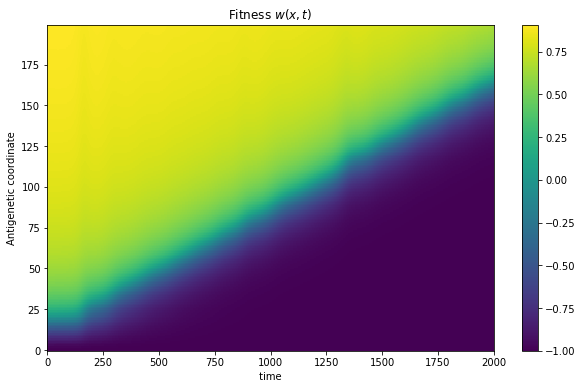

In [15]:
plt.figure(figsize=(10, 6))

plt.imshow(w_all_time,  origin = 'lower', aspect = "auto")
 

plt.colorbar()
 
plt.title(r"Fitness $w(x,t)$")

plt.xlabel(" time ")
plt.ylabel("Antigenetic coordinate")

Text(0, 0.5, 'Antigenetic coordinate')

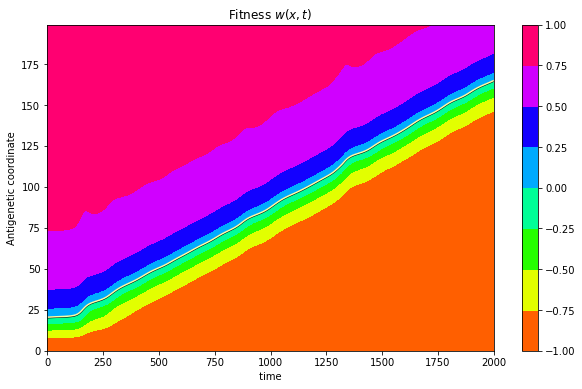

In [16]:
x = np.arange(w_all_time.shape[1])
y = np.arange(w_all_time.shape[0])
X, Y = np.meshgrid(x,y)


plt.figure(figsize=(10, 6))
 

plt.contourf(X, Y, w_all_time, cmap="hsv" )

plt.colorbar()


plt.contour(X, Y, w_all_time, levels = [-0.01, 0.01], cmap="inferno")
 
 
plt.title(r"Fitness $w(x,t)$")

plt.xlabel(" time ")
plt.ylabel("Antigenetic coordinate")

In [17]:
w_all_time.shape

(200, 2001)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 

(-2, 2)

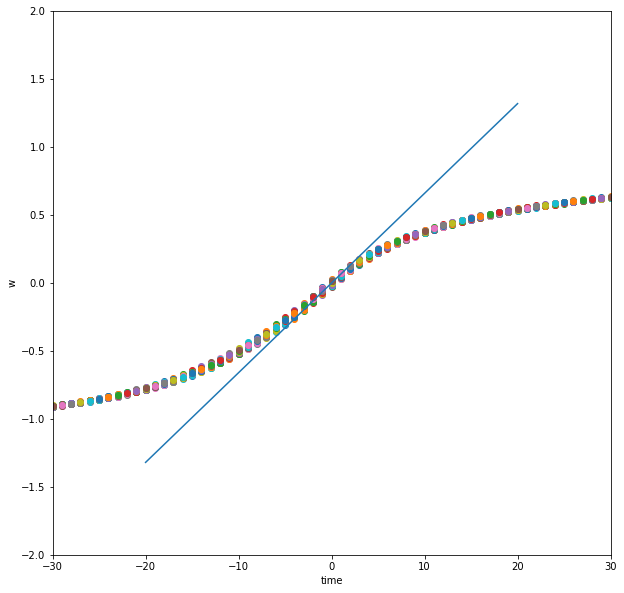

In [18]:
plt.figure(figsize=(10, 10))

d = 2 #чтобы было условие u<<a
xplot = []
yplot = []
for i in range(1, len(i_all_time[0])):
    if(i%50!=0):
        continue
        
    delta_x =  np.argmin(np.abs( w_all_time[:, i-1]) )
    for j in range(len(i_all_time)):
        #u = j - c[i-1]*(i)*h
        #u = j - 0.036*(i) 
        #if(abs(u)<abs(a) ):
        if (i>750 ):
            plt.scatter(j - delta_x, w_all_time[j][i-1])
            xplot.append(j - delta_x)
            yplot.append(w_all_time[j][i-1])
        #plt.scatter(i, delta_x )
        
    if(i%50==0):
        print(i, end = " ")
        
plt.xlabel("time")
plt.ylabel("w")
plt.plot([-20, 20], [-20*0.066, 20*0.066])

plt.xlim(-30, 30)
plt.ylim(-2, 2)

Прямая линия - линия с наклоном $\sigma = 0.066$ (взяла значение из статьи)

Wave speed from $\frac{N_{inf}}{N} = \frac{2 R_0 c}{\pi a}$

Text(0.5, 0, 'time')

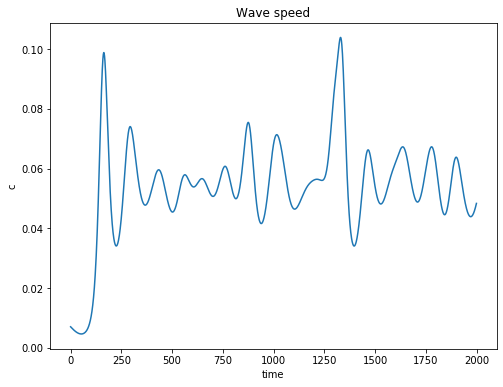

In [19]:
plt.figure(figsize=(8, 6))

plt.plot(c) 

plt.title("Wave speed")
plt.ylabel("c")
plt.xlabel("time")

 
 

In [20]:
 
d = 2 #чтобы было условие u<<a

newK = []
newR = []
for i in range(1, len(i_all_time[0])):
    #if(i%50!=0):
        #continue
    #newK.append([])
    delta_x =  np.argmin(np.abs( w_all_time[:, i-1]) )
    #for j in range(len(i_all_time)):
        #newK.append( )
        
    newR.append(r_all_time[ delta_x,i] )
    #newK.append(a/(a+ delta_x )/(a+delta_x ) )
    #newK.append(a/(a - delta_x )/(a - delta_x ) )
    newK.append(a/(a - delta_x   )/(a - delta_x    ) )
        #u = j - 0.036*(i) 
        
        #newK[-1].append(a/(a+0.36*i+u)/(a+0.36*i+u))
        
        #u = j - c[i-1]*(i)*h
        #u = j - 0.036*(i) 
        #if(abs(u)<abs(a) ):
        #if (i>750 ):
            #plt.scatter(j - delta_x, w_all_time[j][i])
        #plt.scatter(i, delta_x )
        
    #if(i%50==0):
        #print(i, end = " ")
        
        
newK = np.array(newK) 
newR = np.array(newR)
 

In [21]:
newK

array([-0.01070155, -0.01070155, -0.01070155, ..., -0.00029727,
       -0.00029727, -0.00029727])

In [22]:
np.dot(newK.T, newR) 

-0.08962402629420282

In [23]:
q1 = -  np.dot(newK, newR) 
q1 

0.08962402629420282

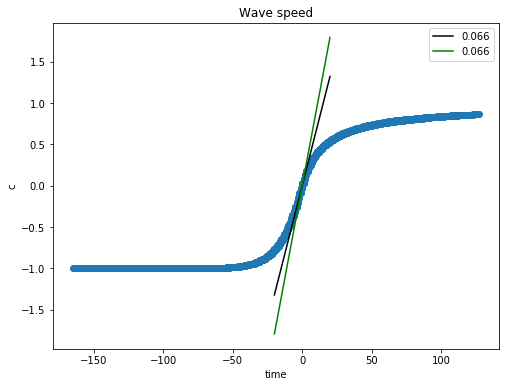

In [24]:
plt.figure(figsize=(8, 6))

plt.scatter(xplot, yplot) 

plt.plot([-20, 20], [-20*0.066, 20*0.066], c= "k", label = "0.066")
 

plt.plot([-20, 20], [-20*q1, 20*q1], c= "g", label = "0.066")

plt.title("Wave speed")
plt.ylabel("c")
plt.xlabel("time")
plt.legend()

#plt.xlim(-30, 30)
#plt.ylim(-2, 2)

In [25]:
def K_integrate(u):
    return (u<0)*u/(u+a)

def r_integrate(u, A):
    integralPart = integrate.quad(K_integrate, u, 0-1e-7)[0]
    return A * np.exp(-A * R0 * integralPart)

def k_r_integrate(u,A):
    
    d_k = a/(u+a)/(u+a)
    
    integralPart = integrate.quad(K_integrate, u, 0-1e-7)[0]
    
    rpart = A * np.exp(-A * R0 * integralPart)
    
    return rpart*d_k

 

In [26]:
integrate.quad(r_integrate, -np.inf, 0-1e-7, args = (0.1))[0]

1.2058550874814624

In [28]:
def normal(i, u):

    return np.sum(i+u)-1

def system(A, u_check):
    
    i_check = np.zeros(len(u_check))
    i_check[mstart] = 0.001*A
    r_check = np.zeros(len(u_check))
    
 
    r_sum = integrate.quad(r_integrate, -np.inf, 0-1e-7, args = (A))[0]
    return r_sum+np.sum(i_check)-1
    
 

0.055545207883053165


Text(0, 0.5, 'recovered density')

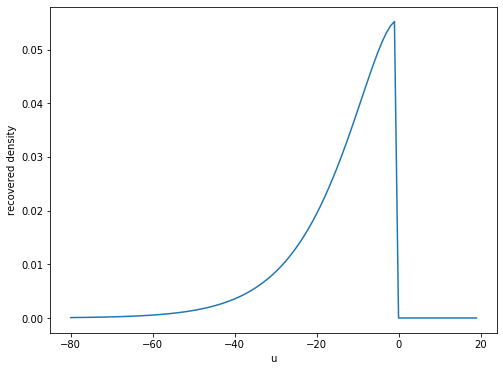

In [31]:
mstart = 80
u_check = np.arange(-mstart, 20, 1)

import scipy.optimize

A = scipy.optimize.fsolve(system, 0.20, args = (u_check))[0]

print(A)

i_check = np.zeros(len(u_check))
i_check[mstart] = 0.001*A
r_check = np.zeros(len(u_check))

dK = np.zeros(len(u_check))
for i in range(len(u_check)):
    if (u_check[i]<0):
        #dK[i]= u_check[i]/(u_check[i]+a)
        dK[i]= a/(u_check[i]+a)/(u_check[i]+a)
        integralPart = integrate.quad(K_integrate, u_check[i], 0-1e-7)[0]

        r_check[i] = A * np.exp(-A * R0 * integralPart)
    
    else:
        dK[i] = 0
        r_check[i] = 0
        
    
 
        
plt.figure(figsize=(8, 6))
 
        
plt.plot(u_check, r_check)

#plt.plot(u_check, dK)


plt.xlabel("u")
plt.ylabel("recovered density")

In [32]:
sigma_eq_3 = -R0 * integrate.quad(k_r_integrate, -np.inf, 0-1e-7, args = (A))[0]

sigma_eq_3

0.0662513243905084